## Lung Segmentation using UNets

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import os, os.path as osp

import numpy as np
import imgaug.augmenters as iaa

from deeply.model.unet import (
    UNet,
    AttentionUNet,
    Trainer
)
from deeply.plots import segplot, history as history_plot
from deeply.datasets.util import split as split_dataset
from deeply.generators import ImageMaskGenerator

from bpyutils.util.system import makedirs

from deeply.util.  import augment as augment_images

from bpyutils._compat import iteritems

import deeply.datasets as dd

import tqdm.notebook as tq

#### Constants

In [3]:
image_size    = (256, 256)
width, height = image_size
batch_size = 1

split_types = ("train", "val", "test")

#### Build Model

In [4]:
unet = UNet(x = width, y = height, n_classes = 1, final_activation = "sigmoid",
            batch_norm = False, padding = "same")

2021-09-02 19:01:36.317432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


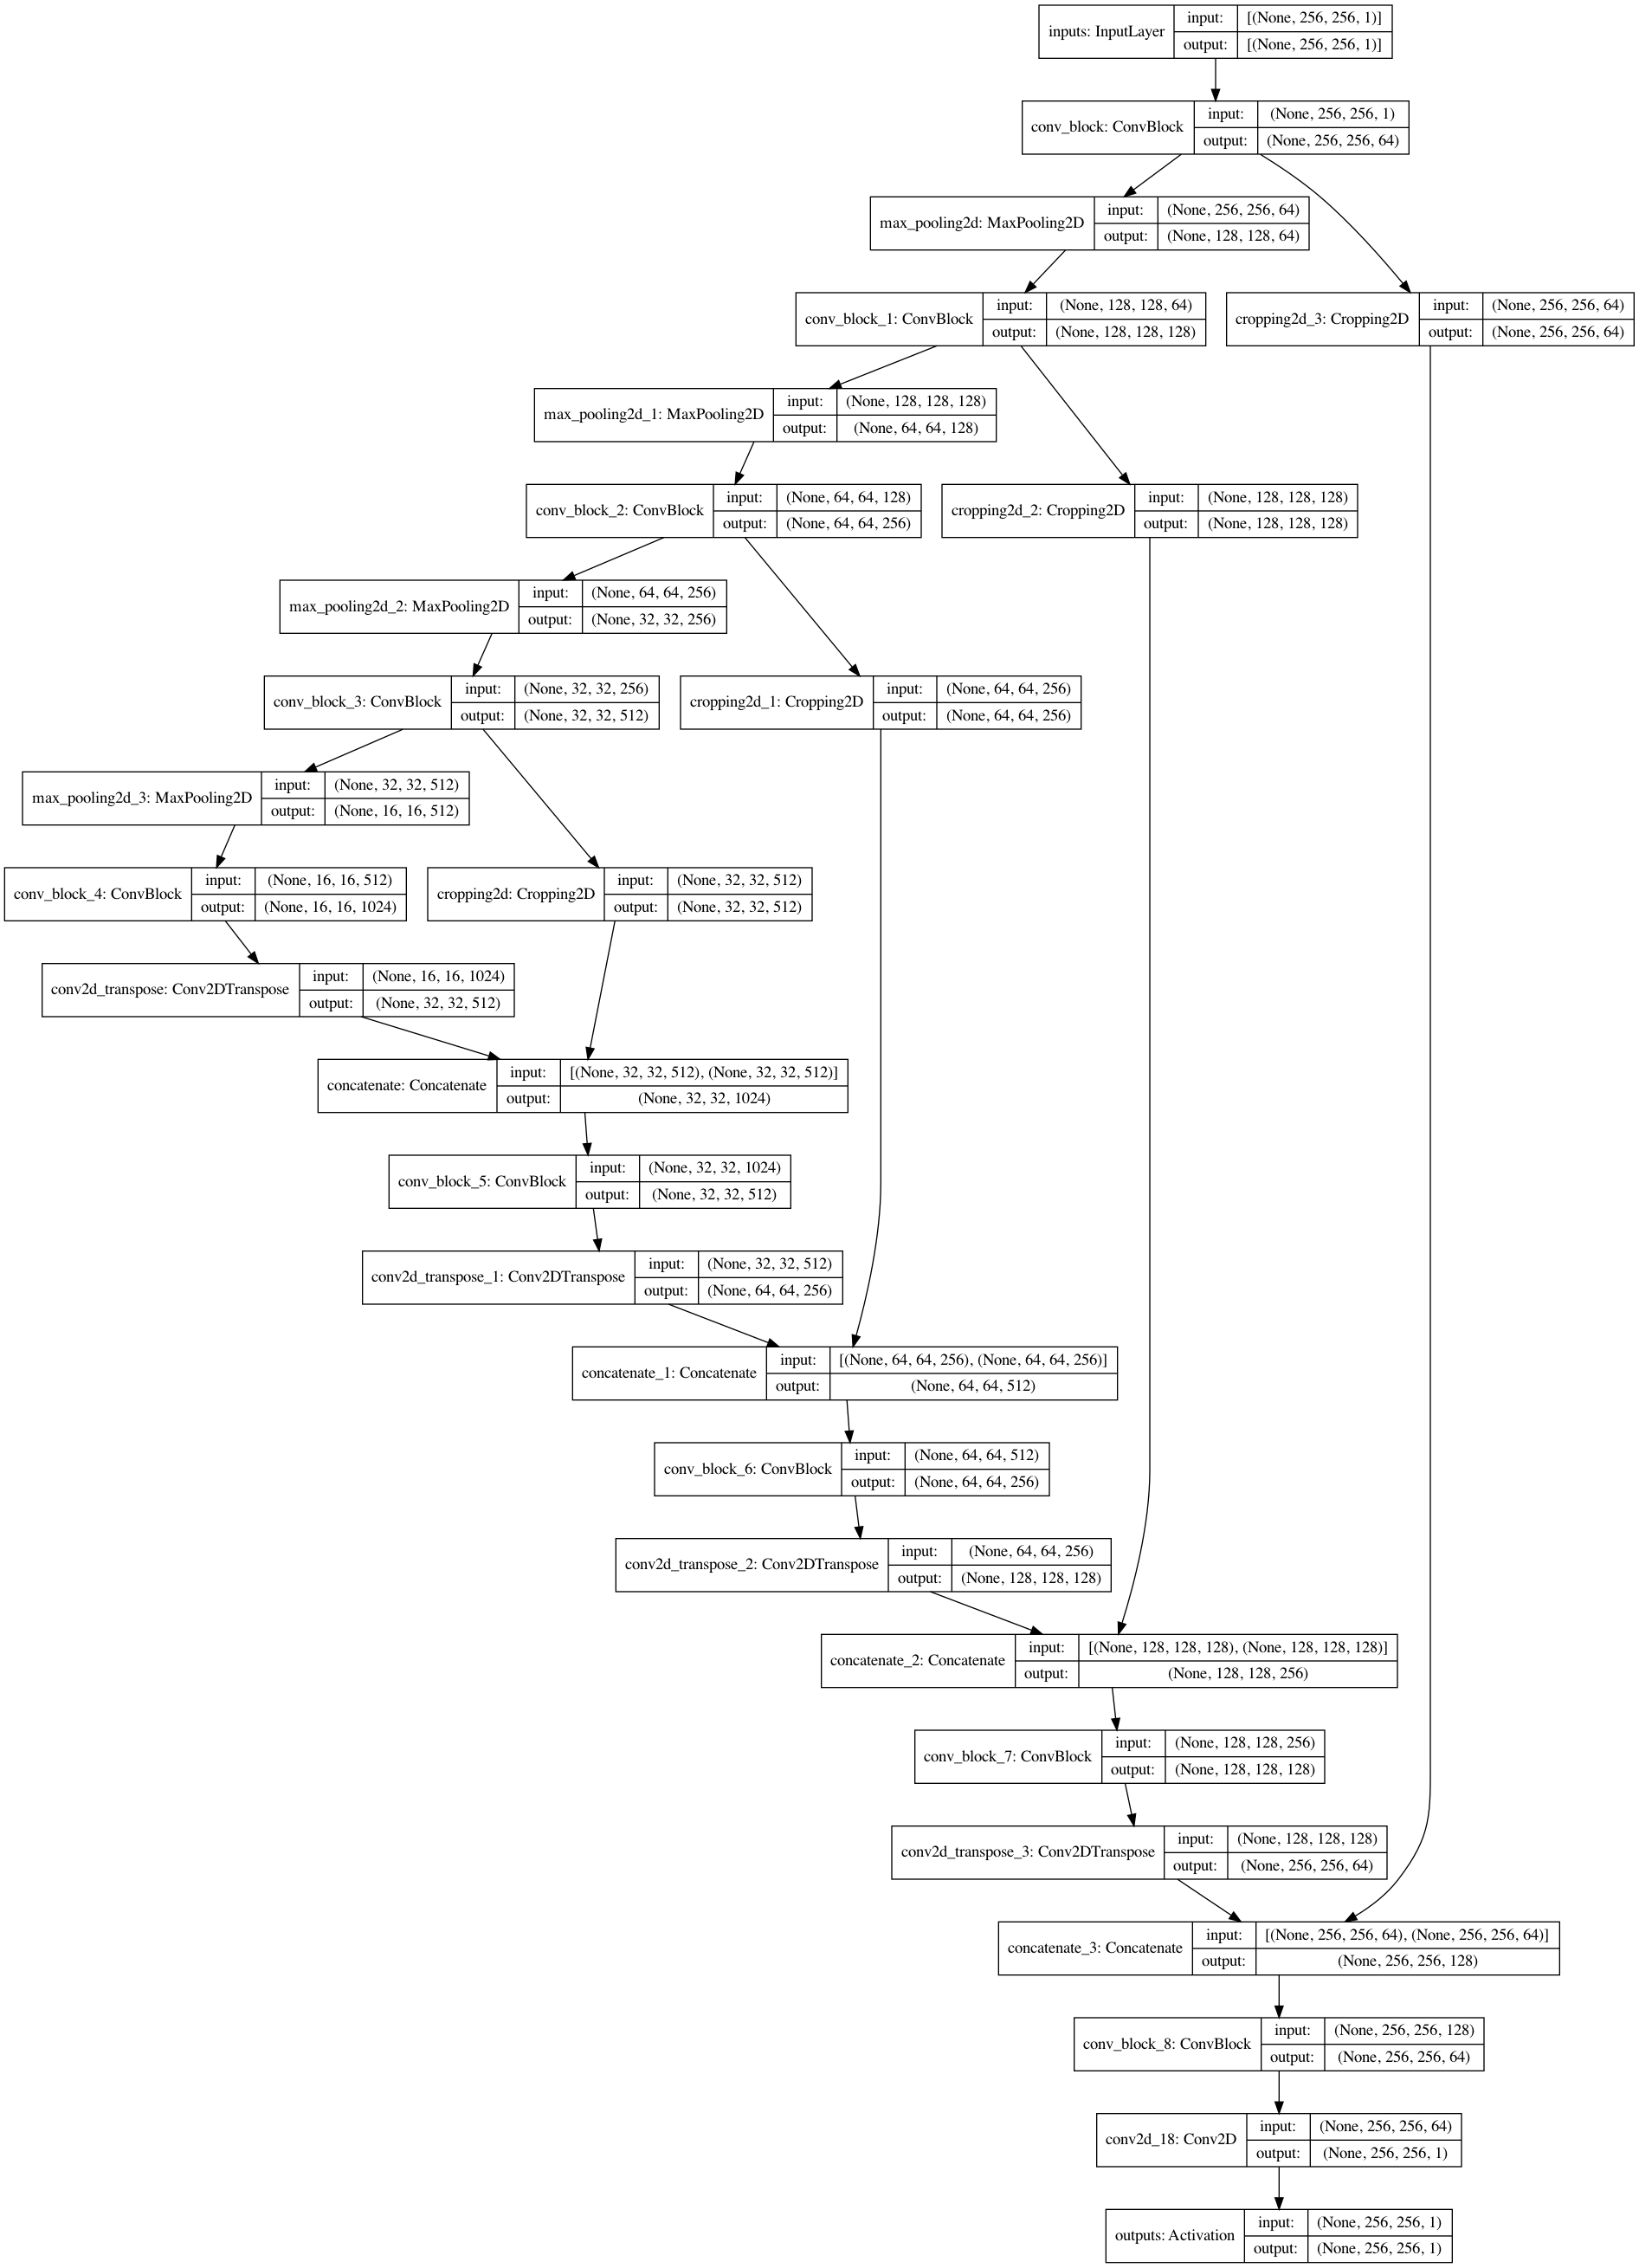

In [5]:
unet.plot()

In [6]:
output_shape = unet.output_shape[1:-1]

#### Prepare Dataset

In [7]:
!rm -rf ./data

In [ ]:
names   = ("montgomery",)

image_augmentor = iaa.Sequential([
    iaa.Resize({ "width": width, "height": height }),
    iaa.CLAHE(
        from_colorspace = iaa.CLAHE.RGB,
        to_colorspace   = iaa.CLAHE.HSV
    )
])

mask_augmentor  = iaa.Sequential([
    iaa.Resize({ "width": output_shape[0], "height": output_shape[1] })
])

for name in names:
    dataset = split_dataset(dd.load(name, shuffle_files = True)["data"])
    groups  = dict(zip(split_types, dataset))
    
    for split_type, split in iteritems(groups):
        print("Generating %s images..." % split_type)
        
        dir_name = osp.join("data", split_type)
        makedirs(dir_name, exist_ok = True)

        for i, data in enumerate(tq.tqdm(split.batch(1))):
            augment_images(image_augmentor, images = data["image"].numpy(), filename = osp.join(dir_name, "images", "%s.jpg" % i))
            augment_images(mask_augmentor,  images = data["mask"].numpy(),  filename = osp.join(dir_name, "masks",  "%s.jpg" % i))

2021-09-02 19:01:45.195827: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
args = dict(batch_size = batch_size, color_mode = "grayscale", image_size = image_size, mask_size = output_shape, shuffle = True)
train, val, test = [ImageMaskGenerator("data/%s/images" % type_, "data/%s/masks" % type_, **args) for type_ in split_types]

#### Show Samples

In [ ]:
from itertools import islice

In [ ]:
n_samples = 3

In [ ]:
samples = islice(test, n_samples)

In [ ]:
for image, mask in samples:
    segplot(image[0], mask[0])

In [ ]:
from tensorflow.keras.optimizers import Adam

from deeply.losses import dice_loss

In [ ]:
unet.compile(optimizer = Adam(learning_rate = 1e-5), loss = dice_loss)

In [ ]:
epochs = 10

#### Preprocess Data

In [ ]:
trainer = Trainer()
history = trainer.fit(unet, train, val = val, epochs = epochs)

In [ ]:
history_plot(history, figsize = (6, 12))

In [ ]:
_ = unet.evaluate(test)

In [ ]:
predict = unet.predict(test)

In [ ]:
from deeply.metrics import jaccard_index, dice_coefficient

In [ ]:
for i, (image, mask) in enumerate(test):
    jaccard = np.round(jaccard_index(mask[0], predict[i]).numpy(), 2)
    dice    = np.round(dice_coefficient(mask[0], predict[i]).numpy(), 2)
    
    title   = "Jaccard's Index: %s, Dice Coefficient: %s" % (jaccard, dice)
    
    segplot(image[0], mask[0], predict[i], super_title = title)